In [1]:
from read_data import load_dataset, get_synth_data
import matplotlib.pyplot as plt
#from losses import *
import numpy as np
import pickle
from models.ensemble import Ensemble
from models.dropout import Dropout
from models.evidental import Evidental
from models.evidental_gauss import EvidentalGauss
import tensorflow_probability as tfp
tfd = tfp.distributions

2023-07-01 17:30:37.347797: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-01 17:30:37.420316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-01 17:30:37.424100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 17:30:39.905481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from quantilelosses import quant_evi_loss

In [3]:
def get_hparams(dataset, model):
    # open pickle file
    with open('hparams/' + dataset + '/' + model + '.pickle', 'rb') as handle:
        hparams = pickle.load(handle)
    return hparams['params']


datasets = ['boston', 'concrete', 'energy-efficiency', 'kin8nm', 'naval', 'protein', 'power-plant', 'wine', 'yacht']
models = ['dropout', 'ensemble', 'evidental']

for d in datasets:
    print(d)
    for m in models:
        print(get_hparams(d, m))

boston
{'batch_size': 125.8220338018792, 'dropout': 0.39646617693280706, 'lr': 0.004749986842054625}
{'batch_size': 125.8220338018792, 'dropout': 0.39646617693280706, 'lr': 0.004749986842054625}
{'batch_size': 63.756999096332805, 'dropout': 0.4523105646165684, 'lr': 0.0021473655076930625}
concrete
{'batch_size': 94.0045487869605, 'dropout': 0.2144557339801518, 'lr': 0.0011419887532853736}
{'batch_size': 94.0045487869605, 'dropout': 0.2144557339801518, 'lr': 0.0011419887532853736}
{'batch_size': 65.11855675430206, 'dropout': 0.1402757486459747, 'lr': 0.00042796586411506654}
energy-efficiency
{'batch_size': 65.18456270795963, 'dropout': 0.12854472299430145, 'lr': 0.001779653101206466}
{'batch_size': 65.18456270795963, 'dropout': 0.12854472299430145, 'lr': 0.001779653101206466}
{'batch_size': 65.12009140411794, 'dropout': 0.12387115864382735, 'lr': 0.001996240834098853}
kin8nm
{'batch_size': 98.6592345855439, 'dropout': 0.15477179580908645, 'lr': 0.0014895534219560853}
{'batch_size': 98.6

In [4]:
(x_train, y_train), (x_test, y_test), y_train_mu, y_train_scale = load_dataset("concrete")

Loading dataset concrete....
Done loading dataset concrete


In [5]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    scale[scale<1e-10] = 1.0

    data = (data - mu) / scale
    return data, mu, scale

In [6]:
def get_dist(which, x):
    return {
        'Gaussian': tfd.Normal(0, 3 * abs(x)+0.2),
        'Expo': tfd.Exponential(rate=1/(2 * abs(x)+0.2))
    }[which]


def get_synth_data(name = 'Gaussian', x_min=-4, x_max=4, n=1000, quantiles = [0.5], train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)
    
    sigma = 3 * abs(x)+0.2 if train else np.zeros_like(x)
    dist = get_dist(name, x)
    y = dist.sample().numpy().astype(np.float32)    

    return x, y, dist.quantile(quantiles).numpy().astype(np.float32)


In [7]:
x_train, y_train, y_train_q95 = get_synth_data('Expo', x_min=-4,x_max= 4, n=1000, train=True, quantiles=[0.05, 0.95])
x_test, y_test, y_test_q95 = get_synth_data('Expo', -4, 4, n=1000, train=True, quantiles=[0.05, 0.95])

x_plot, y_plot,  _ = get_synth_data('Gaussian', -7, 7, n=100, train=True)

x_train, x_train_mu, x_train_scale = standardize(x_train)
x_test = (x_test - x_train_mu) / x_train_scale

x_plot = (x_plot - x_train_mu) / x_train_scale

y_train, y_train_mu, y_train_scale = standardize(y_train)
y_test = (y_test - y_train_mu) / y_train_scale
y_plot = (y_plot - y_train_mu) / y_train_scale


In [8]:
#hpara = get_hparams("boston", "evidental")
Evi = Evidental(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            coeff=3e-1,
            learning_rate=3e-3,
            patience=5000)


eve_g = EvidentalGauss(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=5000)

#hpara = get_hparams("boston", "dropout")
Drop = Dropout(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=5000)

#hpara = get_hparams("boston", "ensemble")
Ense = Ensemble(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=3e-5,
            activation='relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=5000)


print(Evi.drop_prob)
print(Drop.drop_prob)
print(Ense.drop_prob)

0.1
0.1
0.1


In [9]:
eve_g.train(x_train, y_train, batch_size=128, epochs=5000)
Drop.train(x_train, y_train, batch_size=128, epochs=5000)
#Ense.train(x_train, y_train, batch_size=int(hpara['batch_size']), epochs=1000)
Evi.train(x_train, y_train, batch_size=128, epochs=5000)

Epoch 1/5000
8/8 - 2s - loss: 1.2087 - val_loss: 3.4560 - 2s/epoch - 235ms/step
Epoch 2/5000
8/8 - 0s - loss: 1.1291 - val_loss: 2.3496 - 52ms/epoch - 6ms/step
Epoch 3/5000
8/8 - 0s - loss: 1.0332 - val_loss: 2.5000 - 50ms/epoch - 6ms/step
Epoch 4/5000
8/8 - 0s - loss: 0.9950 - val_loss: 2.3609 - 51ms/epoch - 6ms/step
Epoch 5/5000
8/8 - 0s - loss: 0.9099 - val_loss: 2.0184 - 52ms/epoch - 7ms/step
Epoch 6/5000
8/8 - 0s - loss: 0.8460 - val_loss: 2.0572 - 50ms/epoch - 6ms/step
Epoch 7/5000
8/8 - 0s - loss: 0.8160 - val_loss: 2.0862 - 50ms/epoch - 6ms/step
Epoch 8/5000
8/8 - 0s - loss: 0.7792 - val_loss: 1.9198 - 52ms/epoch - 6ms/step
Epoch 9/5000
8/8 - 0s - loss: 0.7819 - val_loss: 1.9343 - 53ms/epoch - 7ms/step
Epoch 10/5000
8/8 - 0s - loss: 0.8180 - val_loss: 1.8984 - 52ms/epoch - 7ms/step
Epoch 11/5000
8/8 - 0s - loss: 0.7728 - val_loss: 1.9664 - 50ms/epoch - 6ms/step
Epoch 12/5000
8/8 - 0s - loss: 0.7623 - val_loss: 1.9302 - 50ms/epoch - 6ms/step
Epoch 13/5000
8/8 - 0s - loss: 0.7556

In [10]:
print("Evidence: ", Evi.evaluate(x_train, y_train, y_train_mu, y_train_scale))
print("Dropout: ", Drop.evaluate(x_train, y_train, y_train_mu, y_train_scale))
print("Ensemble: ", Ense.evaluate(x_train, y_train, y_train_mu, y_train_scale))

print("Evidence: ", Evi.evaluate(x_test, y_test, y_train_mu, y_train_scale))
print("Dropout: ", Drop.evaluate(x_test, y_test, y_train_mu, y_train_scale))
print("Ensemble: ", Ense.evaluate(x_test, y_test, y_train_mu, y_train_scale))

Evidence:  (0.81370777, 5.6689234, 0.0067520618438720705)
Dropout:  (0.8204785, 5.4974866, 0.06658482551574707)
Ensemble:  (3.5577548, 9.653494, 0.02843291759490967)
Evidence:  (0.79205614, 5.82127, 0.006473267078399658)
Dropout:  (0.766774, 5.559416, 0.0662473201751709)
Ensemble:  (3.4701962, 9.628346, 0.02811774015426636)


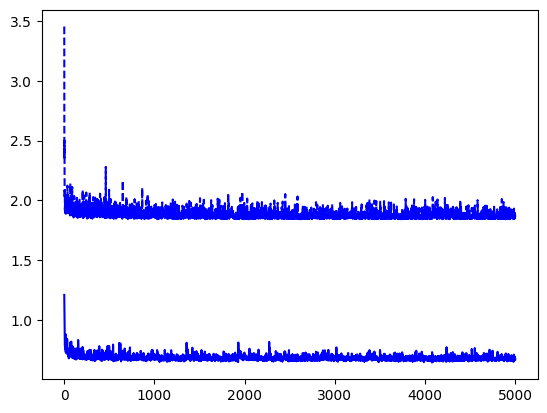

In [11]:
#plt.plot(Evi.history.history['val_nll_eval'], c='red', linestyle='--')
#plt.plot(Evi.history.history['nll_eval'], c='red', label='Evidental')
#plt.plot(Drop.history.history['val_loss'], c='blue', linestyle='--')
#plt.plot(Drop.history.history['loss'], c='blue', label='Dropout')
plt.plot(eve_g.history.history['val_loss'], c='blue', linestyle='--')
plt.plot(eve_g.history.history['loss'], c='blue', label='Dropout')
#plt.plot(Ense.history[0].history['val_loss'], c='green', linestyle='--')
#plt.plot(Ense.history[0].hi
# story['loss'], c='green', label='Ensemble')
#plt.legend()
#plt.show()
#plt.plot(Evi.history.history['val_loss'], c='red', linestyle='--')
#plt.plot(Evi.history.history['loss'], c='red', label='Evidental')
#plt.show()

In [12]:
evi_preds = Evi.predict(x_plot)
drop_preds = Drop.predict(x_plot)
ense_preds = Ense.predict(x_test)

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
output = eve_g.model(x_plot)
mu, v, alpha, beta = tf.split(output, 4, axis=-1)

In [14]:
dist = tfd.Normal(loc=(mu*y_train_scale) + y_train_mu, scale=y_train_scale*np.sqrt(beta/(v*(alpha-1))))

(-5.0, 75.0)

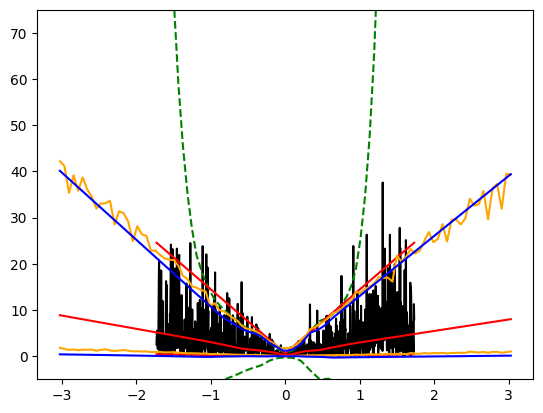

In [15]:
plt.plot(x_test, y_test* y_train_scale + y_train_mu, c='black')
#plt.plot(x_test, mu)
#plt.plot(x_test, mu + 2*np.sqrt(beta/(v*(alpha-1))))
#plt.plot(x_test, mu - 2*np.sqrt(beta/(v*(alpha-1))))
plt.plot(x_plot, dist.mean(), c='red')
plt.plot(x_plot, dist.quantile([0.95]), '--', c='green')
plt.plot(x_plot, dist.quantile([0.05]), '--', c='green')
plt.plot(x_test, y_test_q95[:,0], c='red')
plt.plot(x_test, y_test_q95[:,1], c='red')
plt.plot(x_plot, tf.expand_dims(drop_preds[:,1],1)* y_train_scale + y_train_mu, c='orange')
plt.plot(x_plot, tf.expand_dims(drop_preds[:,0],1)* y_train_scale + y_train_mu, c='orange')
plt.plot(x_plot, tf.expand_dims(evi_preds[:,1],1)* y_train_scale + y_train_mu, c='blue')
plt.plot(x_plot, tf.expand_dims(evi_preds[:,0],1)* y_train_scale + y_train_mu, c='blue')
plt.ylim(-5, 75)

In [16]:
#errors_evi = (y_test_q95-(evi_preds* y_train_scale + y_train_mu))
#errors_drop = (y_test_q95-(drop_preds* y_train_scale + y_train_mu))
#errors_gauss = (y_test_q95-(dist.quantile([0.05, 0.95])))

In [17]:
plt.plot(x_test, errors_gauss[:,1], label='Gauss')
plt.plot(x_test, errors_drop[:,1], label='Dropout')
plt.plot(x_test, errors_evi[:,1], label='Evidental')
plt.legend()

NameError: name 'errors_gauss' is not defined

In [ ]:
plt.plot(x_test, (mu*y_train_scale) + y_train_mu)
plt.plot(x_test, y_test)

In [ ]:
plt.plot(x_test, mu,'o')
#plt.plot(x_test, y_test)

In [ ]:
print("Evidence")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(evi_preds[:,i],1)).numpy().mean()))

print("Dropout")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(drop_preds[:,i],1)).numpy().mean()))

print("Ensemble")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(ense_preds[:,i],1)).numpy().mean()))


In [ ]:
#print(tf.reduce_mean(y_test-tf.expand_dims(evi_preds[:,1],1)**2))
#print(tf.reduce_mean(y_test-tf.expand_dims(drop_preds[:,1],1)**2))
#print(tf.reduce_mean(y_test-tf.expand_dims(ense_preds[:,1],1)**2))

In [ ]:
#plt.figure(figsize=(10,10))
#plt.plot(y_test)
#plt.plot(evi_preds[:,0], label='Evidential')
#plt.plot(drop_preds[:,0], label='Evidential')
#plt.scatter(y_test, evi_preds[:,1], label='Evidential')
#plt.scatter(y_test, drop_preds[:,1], label='Dropout')
#plt.scatter(y_test, ense_preds[:,1], label='Ensemble')
#plt.plot(y_test, y_test, label='Ground Truth')
#plt.legend()

In [ ]:
def plot_q(x_train, y_train, x_test, y_test, model):
    #mu, var_ = model.get_mu_sigma(x_test)
    mu = model.predict(x_test)
    var_ = model.get_uncertainties(x_test)
    mu = (mu*y_train_scale) + y_train_mu
    var_ = var_*y_train_scale
    y_test = (y_test*y_train_scale) + y_train_mu
    y_train = (y_train*y_train_scale) + y_train_mu
    x_train = (x_train*x_train_scale) + x_train_mu
    x_test = (x_test*x_train_scale) + x_train_mu
    for i, q in enumerate(model.quantiles):
        plot_predictions(x_train, y_train, x_test, y_test, mu[:,i], var=var_[:,i], quantile=q, n_stds=4, kk=i)

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, var, quantile, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    x_train = x_train[:, 0]
    #var = np.minimum(var, 1e3)  # for visualization
    plt.figure(figsize=(5, 3), dpi=200)
    plt.title("Quantile: {:.2f}".format(quantile))
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    #plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.scatter(x_test, y_test, c='r',s=1., zorder=2, label="True")
    plt.plot(x_test, y_pred, color='#007cab', zorder=3, label="Pred")
    #plt.plot(x_test, mu_z, color='green', zorder=3, label="Pred_or")
    #plt.plot(x_test, mu_z+2*std_z, color='green', linestyle='--', zorder=3, label="Pred_or")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

    for k in np.linspace(0, n_stds, 4):
        #print(var.shape)
        #print(mu.shape)
        #print((k*var).shape)
        plt.fill_between(
            x_test, (y_pred - k * var), (y_pred + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    #plt.gca().set_ylim(-5, 5)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()


In [ ]:
print("Evidence")
plot_q(x_train, y_train, x_test, y_test, Evi)
print("Dropout")
plot_q(x_train, y_train, x_test, y_test, Drop)
print("Ensemble")
plot_q(x_train, y_train, x_test , y_test, Ense)


Evidence


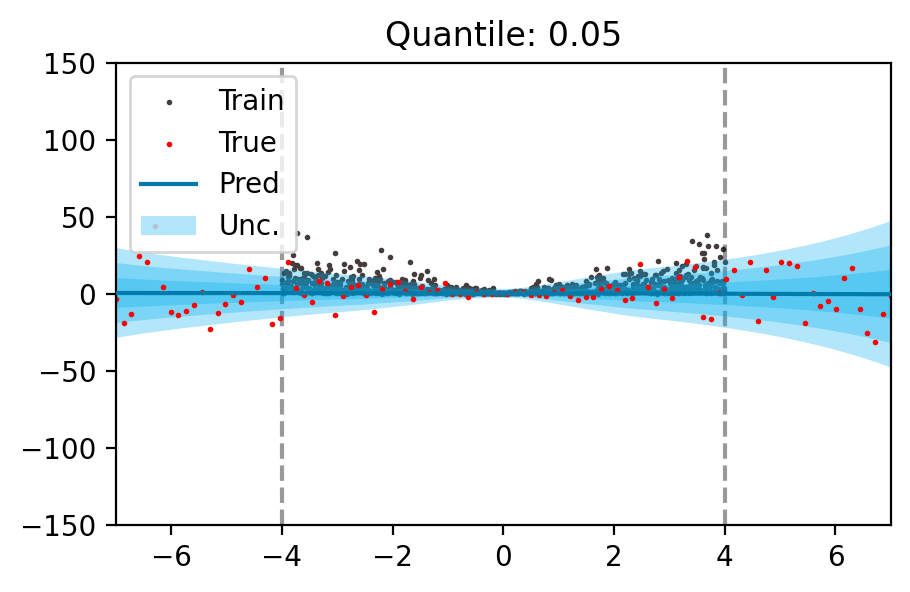

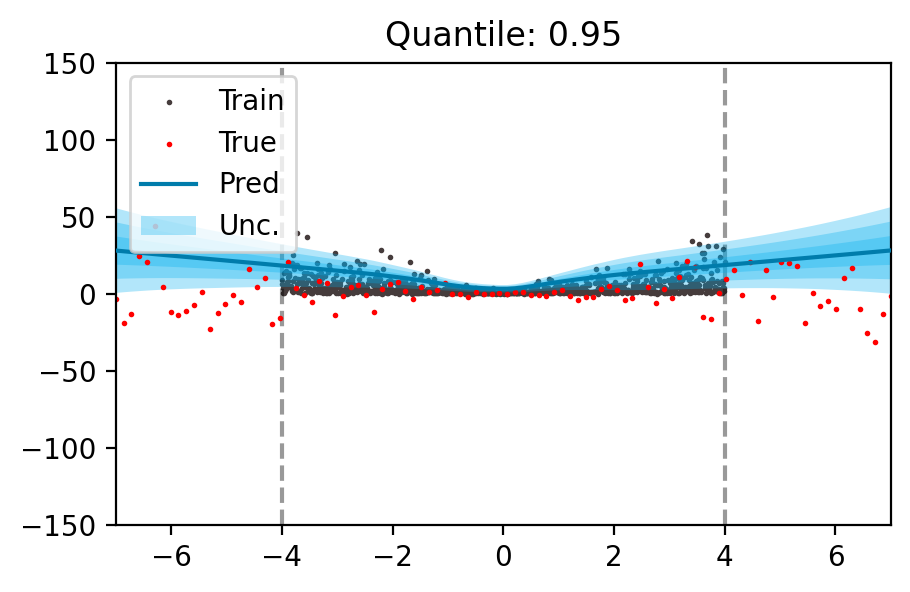

Dropout


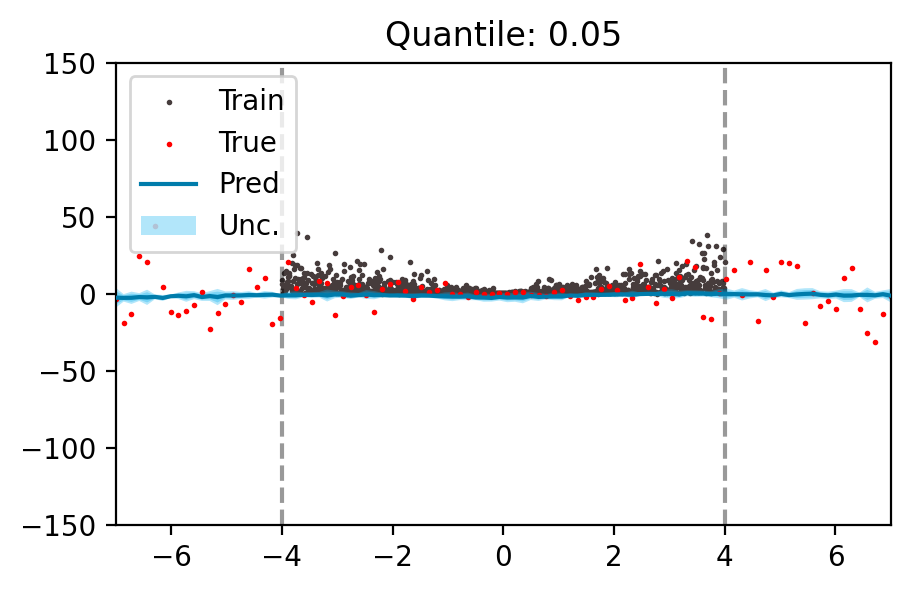

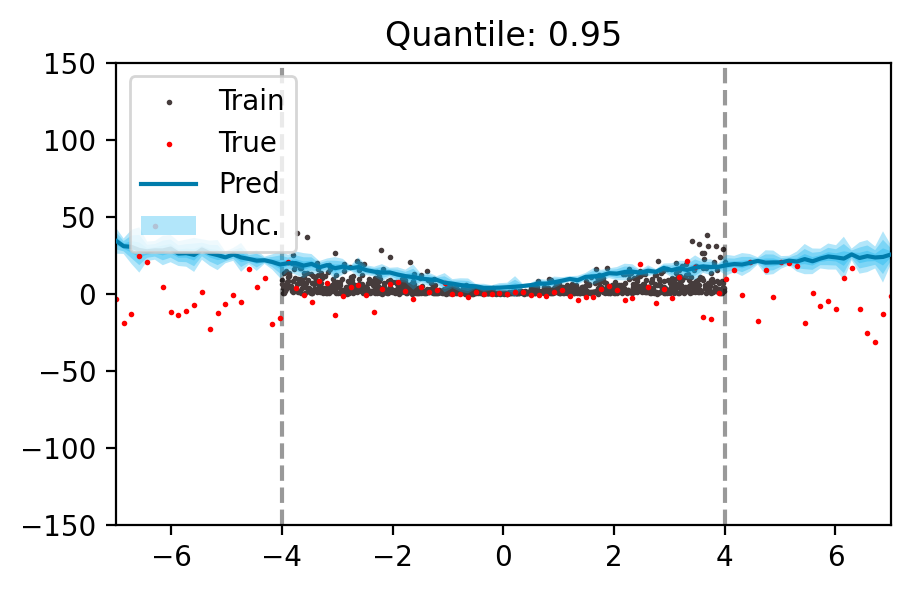

Ensemble


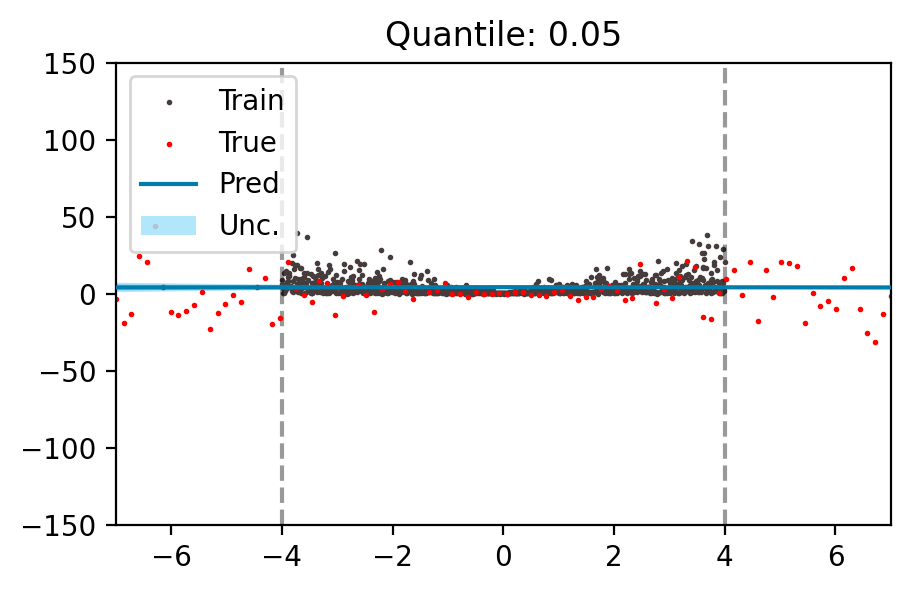

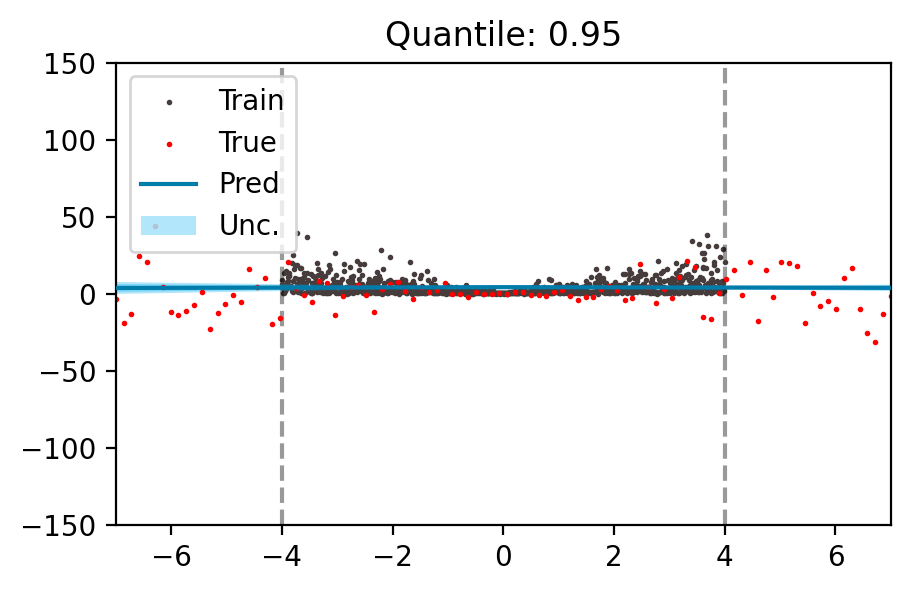

In [ ]:
print("Evidence")
plot_q(x_train, y_train, x_plot, y_plot, Evi)
print("Dropout")
plot_q(x_train, y_train, x_plot, y_plot, Drop)
print("Ensemble")
plot_q(x_train, y_train, x_plot, y_plot, Ense)